# Sentiment Classification Using RNNs

* Given the IMDB Movie Review Dataset, create an RNN model that predicts whether the given review is negative or positive.
* You need to create your Dataset, Dataloader and Model. Keep your code modular and avoid hardcoding any parameter. This will allow you to experiment more easily.
* Plot graphs for loss and accuracy for each epoch of a training loop. Try using wandb for logging training and validation losses, accuracies.
* Use tqdm to keep track of the status of the training loop for an epoch

### 1. RNN Model
#### 1.1 Build a Dataset from the IMDB Movie Review Dataset by taking reviews with word count between 100 and 500. Perform text processing on the movie reviews and create a word to index mapping for representing any review as a list of numbers.
#### 1.2 Create Dataloaders for the train, test and validation datasets with appropriate batch sizes.
#### 1.3 Create the Model class for the RNN Model. Create functions for running model training and testing.

In [1]:
!pip install datasets torchmetrics

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import Accuracy

from tqdm import tqdm

In [3]:
SEED = 1234

# set seed for all possible random functions to ensure reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
# load the IMDB review dataset. You can take the dataset from Huggingface
imdb_dataset = load_dataset("imdb")

In [6]:
# Split the train set into train and validation in 80-20 split. Use the labels
# to ensure that the ratio of the samples from each label is maintained
print(imdb_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [7]:
#splitting the data based on the above structure of the dataset
from sklearn.model_selection import train_test_split


train_data = imdb_dataset['train']
train_text = train_data['text']
train_labels = train_data['label']

train_texts, valid_texts, train_labels, valid_labels = train_test_split(train_text, train_labels, test_size=0.2, stratify=train_labels, random_state=42)
#stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset
#so using the stratify we can ensuer that the ratio of samples from each label is maintained properly
print(len(train_texts))
print(len(valid_texts))

20000
5000


In [8]:
test_texts = imdb_dataset['test']['text']
test_labels = imdb_dataset['test']['label']

In [9]:
import re

number_pattern = r'\b(?:\d+\.\d+|\.\d+|\d+(?:[\d+\,]+)\d+|\d+)\b'
def number_tokenizer(text):
      #number can be decimal integer or anyting soo i have used the d(digits) for the notation of the nubmer
      l = re.compile(number_pattern).findall(text)
      return l

def replace_number(text):
      numbers = number_tokenizer(text)
      tokenized_text = text
      for i in numbers:
          tokenized_text = tokenized_text.replace(i , "num")

      return(tokenized_text)
def clean(text, tokenizer):
  # Perform text preprocessing:
  # 1. Removing numbers OR replace them with "num" token
  # 2. Convert all characters to lowercase.
  # 3. Tokenize the sentence into words
  # You can use RegexpTokenizer from NLTK.
  text = replace_number(text)

  # Convert all characters to lowercase
  text = text.lower()

  # Tokenize the sentence into words
  words = tokenizer.tokenize(text)

  return ' '.join(words)
  # You will experiment with stemming/lemmatization down the line
  # so you can skip that for now

In [10]:
tokenizer = RegexpTokenizer(r'\w+')

clean_train_texts = [clean(text , tokenizer) for text in train_texts]
clean_valid_texts = [clean(text, tokenizer) for text in valid_texts]


In [11]:
# create a word to index dictionary so that each word in the training set
# has a number associated with it. This allows to represent each sentence
# as a series of numbers. Start the index with 1 instead of 0. The number
# 0 will be used to denote padding, so that each sentence can have the
# same length.
# Keep track of the index since it will be used for representing new words
# that were not part of the training vocabulary.
# Also, make sure to not create dictionary on sentences with word count
# not within the range

def get_word2idx(corpus , maxlen , minlen):
  idx = 1
  word2idx = {}
  #word2idx['pad'] = 0
  for sentence in tqdm(corpus, total=len(corpus), desc="Creating word2idx"):
    # process sentence
    sentence = clean(sentence, tokenizer)
    words = sentence.split()

    # drop sentences greater than maxlen or less than minlen
    if(minlen<=len(words) and len(words)<=maxlen):
      for word in words:
        if word not in word2idx:
          word2idx[word] = idx
          idx += 1
    # for each word in sentence, check for entry in word2idx

  return idx, word2idx



In [12]:
minlen = min([len(sentence) for sentence in train_texts])
maxlen = max([len(sentence) for sentence in train_texts])
print(minlen , maxlen)

52 13704


In [13]:
idx, word2idx = get_word2idx(train_texts, 500, 100)

Creating word2idx:   2%|▏         | 431/20000 [00:00<00:04, 4309.98it/s]

Creating word2idx: 100%|██████████| 20000/20000 [00:04<00:00, 4839.05it/s]


In [14]:
print(len(word2idx))
print(idx)

58775
58776


In [14]:
# Build a Dataset object to store each sentence as a tensor of numbers
# along with the label. Make sure to add padding so that the tensor
# for each sentence is of the same length. This will allow us to train
# the model in batches.
tokenizer = RegexpTokenizer(r'\w+')

class IMDBDataset(Dataset):
  def __init__(self, dataset,labels, word2idx, minlen : int = 100, maxlen : int = 500):
    self.count = 0 # total sentences you finally pick

    # count total number of lines
    #len = len(dataset)

    input_data = []
    target_data = []
    corpus = dataset

    #for idx, sentence in tqdm(enumerate(corpus), total=len, desc=f"Transforming input text [{split}]"):
    for sentence , label in tqdm(zip(dataset,labels),total=len(dataset), desc=f"Transforming input text"):
      # process sentence
      sentence = clean(sentence , tokenizer)
      # drop sentences greater than maxlen or less than minlen
      words = sentence.split()
      if(len(words)<minlen or maxlen<len(words)):continue

      # replace words with their index
      indices= [word2idx.get(word, 0) for word in words]
      #we can pad the sentence right here
      padded_seq = [0]*(maxlen - len(indices))
      padded_indices = indices[:maxlen] + padded_seq

      #pad_sequence doesnt take in list so for the pad_sequence we need to convert the input list to tensor form then it will accept it
      input_data.append(torch.tensor(indices))

      target_data.append(label)

      self.count += 1

    # pad the sentences upto maxlen
    self.inputs = pad_sequence(input_data, batch_first = True)
    #self.inputs = torch.tensor(input_data)
    self.targets = torch.tensor(target_data)

  def __len__(self) -> int:
    return self.count

  def __getitem__(self, index : int):
    return self.inputs[index], self.targets[index]

In [15]:
# create the train dataset using the word2idx dictionary built using the train set
train_ds = IMDBDataset(train_texts , train_labels , word2idx,minlen = 100, maxlen = 500)
# create the validation and test dataset using the word2idx dictionary built using the train set
val_ds = IMDBDataset(valid_texts , valid_labels , word2idx,minlen = 100, maxlen = 500)
test_ds = IMDBDataset(test_texts , test_labels , word2idx,minlen = 100, maxlen = 500)

Transforming input text: 100%|██████████| 25000/25000 [00:06<00:00, 3890.61it/s]


In [16]:
len(train_ds), len(val_ds), len(test_ds)

(16059, 4008, 20078)

In [17]:
# create dataloaders using the dataset
params = {
    'batch_size':300,
    'shuffle': True,

}

train_dataloader = DataLoader(train_ds, **params)
val_dataloader = DataLoader(val_ds, **params)
test_dataloader = DataLoader(test_ds, **params)

In [19]:
import torch.nn.functional as F


class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, num_classes):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers=5, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        embedded = self.embedding(X)
        output, _ = self.rnn(embedded)
        logits = self.fc(output[:, -1, :])  # Using only the last output from the model
        return logits

In [20]:
# Hyperparameters
hidden_size = 256
embedding_dim = 128
learning_rate = 1e-3
epochs = 5
num_classes = len(set(train_labels))
vocab_size = len(word2idx)+1

# create the model
model = RNNModel(vocab_size, hidden_size, embedding_dim,3, num_classes).to(device)

# create optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(model)

RNNModel(
  (rnn): RNN(256, 128, num_layers=5, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


In [18]:
def train_model(model, trainloader, valloader, learning_rate=1e-3, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    val_accuracy = []
    best_val_loss = float('inf')

    for epoch in range(epochs):
        ## TRAINING STEP
        model.train()
        train_loss = 0.0
        for input_batch, output_batch in tqdm(trainloader, total=len(trainloader), desc="Training"):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)

            optimizer.zero_grad() #clearing the gradients
            outputs = model(input_batch) #input to the model

            # Calculate loss
            loss = criterion(outputs, output_batch) #crosee entropy los

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(trainloader)
        train_losses.append(train_loss)

        ## VALIDATION STEP
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for input_batch, output_batch in tqdm(valloader, total=len(valloader), desc="Validation"):
                input_batch, output_batch = input_batch.to(device), output_batch.to(device)

                # Forward pass
                outputs = model(input_batch)

                # Calculate loss
                loss = criterion(outputs, output_batch)
                val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total += output_batch.size(0)
                correct += (predicted == output_batch).sum().item()

        val_loss /= len(valloader)
        val_losses.append(val_loss)
        accuracy = 100 * correct / total
        val_accuracy.append(accuracy)

        print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.2f}%")

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

    model.load_state_dict(best_model_state)
    return train_losses, val_losses, val_accuracy



In [36]:
train_losses, val_losses, val_accuracy = train_model(model, train_dataloader, val_dataloader)

Validation: 100%|██████████| 14/14 [00:00<00:00, 15.51it/s]


Epoch 1/10: Train Loss: 0.6861, Val Loss: 0.7028, Val Accuracy: 51.32%


Validation: 100%|██████████| 14/14 [00:00<00:00, 15.39it/s]


Epoch 2/10: Train Loss: 0.6865, Val Loss: 0.7062, Val Accuracy: 51.22%


Validation: 100%|██████████| 14/14 [00:00<00:00, 14.38it/s]


Epoch 3/10: Train Loss: 0.6863, Val Loss: 0.7054, Val Accuracy: 48.35%


Validation: 100%|██████████| 14/14 [00:00<00:00, 14.75it/s]


Epoch 4/10: Train Loss: 0.6862, Val Loss: 0.7026, Val Accuracy: 51.50%


Validation: 100%|██████████| 14/14 [00:00<00:00, 14.14it/s]


Epoch 5/10: Train Loss: 0.6875, Val Loss: 0.7096, Val Accuracy: 51.37%


Validation: 100%|██████████| 14/14 [00:00<00:00, 15.21it/s]


Epoch 6/10: Train Loss: 0.6878, Val Loss: 0.7041, Val Accuracy: 50.92%


Validation: 100%|██████████| 14/14 [00:00<00:00, 14.95it/s]


Epoch 7/10: Train Loss: 0.6888, Val Loss: 0.7009, Val Accuracy: 48.38%


Validation: 100%|██████████| 14/14 [00:00<00:00, 14.29it/s]


Epoch 8/10: Train Loss: 0.6919, Val Loss: 0.7081, Val Accuracy: 48.35%


Validation: 100%|██████████| 14/14 [00:00<00:00, 15.51it/s]


Epoch 9/10: Train Loss: 0.6944, Val Loss: 0.6933, Val Accuracy: 51.47%


Validation: 100%|██████████| 14/14 [00:00<00:00, 15.27it/s]

Epoch 10/10: Train Loss: 0.6942, Val Loss: 0.6927, Val Accuracy: 51.55%


In [24]:
print(train_losses)
print(val_losses)
print(val_accuracy)

[0.6977404985162947, 0.6943264736069573, 0.6929634831569813, 0.6935779982142978, 0.691804952091641, 0.6945093671480814, 0.6920108916582884, 0.6957535059363754, 0.6960211528672112, 0.6947653150116956]
[0.6933844430106026, 0.6950912049838475, 0.693165408713477, 0.6934919783047268, 0.6940241881779262, 0.6929179131984711, 0.6957318655082158, 0.6963557132652828, 0.6937478865895953, 0.6933844302381788]
[51.57185628742515, 51.54690618762475, 51.59680638722555, 51.49700598802395, 51.44710578842315, 51.57185628742515, 48.47804391217565, 48.42814371257485, 51.54690618762475, 51.57185628742515]


In [31]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for input_batch, output_batch in tqdm(test_loader):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            #get outputs from the trained model
            pred_outputs = model(input_batch)
            _, predicted = torch.max(pred_outputs, dim=1)  # Get predicted class labels
            total += output_batch.size(0)
            correct += (predicted == output_batch).sum().item()

    accuracy = 100 * (correct / total)
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

accuracy = test(model, test_dataloader)


  0%|          | 0/67 [00:00<?, ?it/s]

100%|██████████| 67/67 [00:04<00:00, 14.32it/s]

Test Accuracy: 50.94%


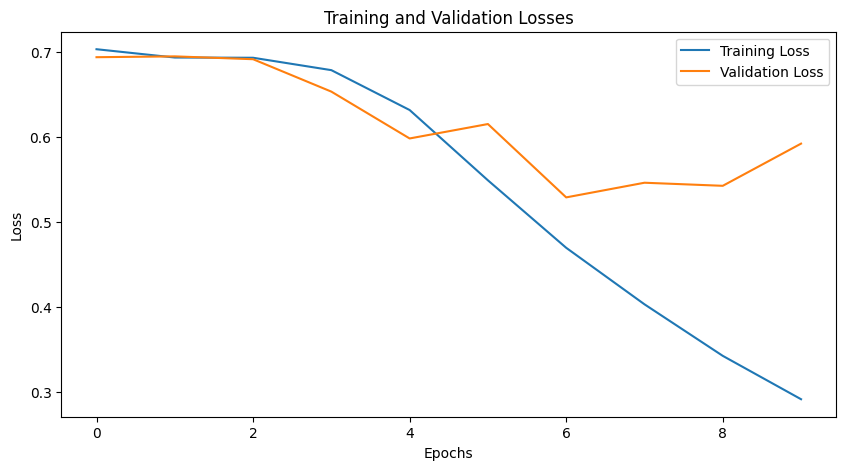

In [ ]:
# plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

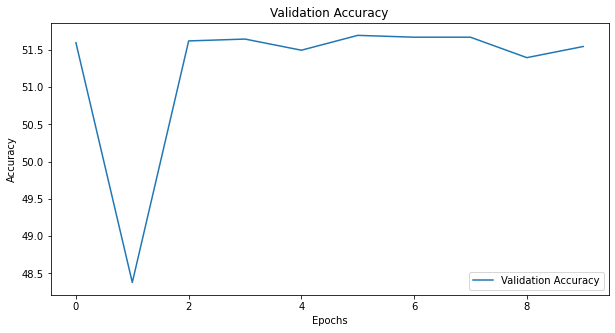

In [32]:
# plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

#### 1.2 Incorporate stemming/lemmatization when doing text preprocessing using the NLTK library. What changes do you observe in accuracy ?

In [33]:
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer

number_pattern = r'\b(?:\d+\.\d+|\.\d+|\d+(?:[\d+\,]+)\d+|\d+)\b'
def number_tokenizer(text):
      #number can be decimal integer or anyting soo i have used the d(digits) for the notation of the nubmer
      l = re.compile(number_pattern).findall(text)
      return l

def replace_number(text):
      numbers = number_tokenizer(text)
      tokenized_text = text
      for i in numbers:
          tokenized_text = tokenized_text.replace(i , "num")

      return(tokenized_text)
def clean(text, tokenizer):
  # Perform text preprocessing:
  # 1. Removing numbers OR replace them with "num" token
  # 2. Convert all characters to lowercase.
  # 3. Tokenize the sentence into words
  # You can use RegexpTokenizer from NLTK.
  text = replace_number(text)

  # Convert all characters to lowercase
  text = text.lower()

  # Tokenize the sentence into words
  words = tokenizer.tokenize(text)

  #stemming
  stemmer = PorterStemmer()
  stemmed_words = [stemmer.stem(word) for word in words]
  return ' '.join(stemmed_words)

tokenizer = RegexpTokenizer(r'\w+')

# create the train dataset using the word2idx dictionary built using the train set
train_ds = IMDBDataset(train_texts , train_labels , word2idx,minlen = 100, maxlen = 500)
# create the validation and test dataset using the word2idx dictionary built using the train set
val_ds = IMDBDataset(valid_texts , valid_labels , word2idx,minlen = 100, maxlen = 500)
test_ds = IMDBDataset(test_texts , test_labels , word2idx,minlen = 100, maxlen = 500)


Transforming input text:   0%|          | 0/20000 [00:00<?, ?it/s]

Transforming input text: 100%|██████████| 25000/25000 [01:23<00:00, 299.39it/s]


In [34]:
# create dataloaders using the dataset
params = {
    'batch_size':300,
    'shuffle': True,
}

train_dataloader = DataLoader(train_ds, **params)
val_dataloader = DataLoader(val_ds, **params)
test_dataloader = DataLoader(test_ds, **params)

hidden_size = 256
embedding_dim = 128
learning_rate = 1e-3
epochs = 5
num_classes = len(set(train_labels))
vocab_size = len(word2idx)+1

# create the model
model1 = RNNModel(vocab_size, hidden_size, embedding_dim,3, num_classes).to(device)


In [35]:
train_losses, val_losses, val_accuracy = train_model(model1, train_dataloader, val_dataloader)

Validation: 100%|██████████| 14/14 [00:00<00:00, 18.05it/s]


Epoch 1/10: Train Loss: 0.6972, Val Loss: 0.6927, Val Accuracy: 51.62%


Validation: 100%|██████████| 14/14 [00:00<00:00, 16.13it/s]


Epoch 2/10: Train Loss: 0.6931, Val Loss: 0.6923, Val Accuracy: 51.62%


Validation: 100%|██████████| 14/14 [00:00<00:00, 15.58it/s]


Epoch 3/10: Train Loss: 0.6930, Val Loss: 0.7020, Val Accuracy: 48.30%


Validation: 100%|██████████| 14/14 [00:00<00:00, 15.42it/s]


Epoch 4/10: Train Loss: 0.6918, Val Loss: 0.6981, Val Accuracy: 48.33%


Validation: 100%|██████████| 14/14 [00:00<00:00, 15.51it/s]


Epoch 5/10: Train Loss: 0.6902, Val Loss: 0.6975, Val Accuracy: 51.62%


Validation: 100%|██████████| 14/14 [00:00<00:00, 15.63it/s]


Epoch 6/10: Train Loss: 0.6900, Val Loss: 0.6975, Val Accuracy: 51.62%


Validation: 100%|██████████| 14/14 [00:00<00:00, 15.88it/s]


Epoch 7/10: Train Loss: 0.6897, Val Loss: 0.7019, Val Accuracy: 51.47%


Validation: 100%|██████████| 14/14 [00:00<00:00, 14.93it/s]


Epoch 8/10: Train Loss: 0.6976, Val Loss: 0.6936, Val Accuracy: 48.48%


Validation: 100%|██████████| 14/14 [00:00<00:00, 14.61it/s]


Epoch 9/10: Train Loss: 0.6928, Val Loss: 0.6938, Val Accuracy: 51.45%


Validation: 100%|██████████| 14/14 [00:00<00:00, 14.88it/s]

Epoch 10/10: Train Loss: 0.6908, Val Loss: 0.6967, Val Accuracy: 51.50%


In [37]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for input_batch, output_batch in tqdm(test_loader):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            #get outputs from the trained model
            pred_outputs = model(input_batch)
            _, predicted = torch.max(pred_outputs, dim=1)  # Get predicted class labels
            total += output_batch.size(0)
            correct += (predicted == output_batch).sum().item()

    accuracy = 100 * (correct / total)
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

accuracy = test(model1, test_dataloader)

100%|██████████| 67/67 [00:04<00:00, 14.20it/s]

Test Accuracy: 50.91%


#### 1.3 In the Model class, experiment with only picking the last output and mean of all outputs in the RNN layer. What changes do you observe ?

- For this the default model takes the last output as the actual output and the model is designed in that way now , which small changes instead of taking the last output i have taken the mean of all the outputs and incorporated the model
- Here in the forward function, After obtaining the output from the RNN layer instead of considering output[:, -1, :] which resembles the last output replace it with the mean of the outputs that is torch.mean(output, dim=1) we get the mean of all the outputs
- This mean of the outputs is used in the model for the prediction outputs


In [19]:
import torch.nn.functional as F


class RNN_Mean_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, num_classes):
        super(RNN_Mean_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers=5, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        embedded = self.embedding(X)
        output, _ = self.rnn(embedded)
        #instead of using the last ouput i use the mean of the outputs
        mean_output = torch.mean(output, dim=1)
        logits = self.fc(mean_output) 
        return logits
    


hidden_size = 256
embedding_dim = 128
learning_rate = 1e-3
epochs = 5
num_classes = len(set(train_labels))
vocab_size = len(word2idx)+1

# create the model
mean_model = RNN_Mean_Model(vocab_size, hidden_size, embedding_dim,3, num_classes).to(device)

# create optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mean_model.parameters(), lr=learning_rate)
print(mean_model)

RNN_Mean_Model(
  (embedding): Embedding(58776, 256)
  (rnn): RNN(256, 128, num_layers=5, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


In [30]:
train_losses, val_losses, val_accuracy = train_model(mean_model, train_dataloader, val_dataloader)
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for input_batch, output_batch in tqdm(test_loader):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            #get outputs from the trained model
            pred_outputs = model(input_batch)
            _, predicted = torch.max(pred_outputs, dim=1)  # Get predicted class labels
            total += output_batch.size(0)
            correct += (predicted == output_batch).sum().item()

    accuracy = 100 * (correct / total)
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

accuracy = test(mean_model, test_dataloader)

Validation: 100%|██████████| 14/14 [00:02<00:00,  5.97it/s]


Epoch 1/10: Train Loss: 0.6724, Val Loss: 0.6875, Val Accuracy: 53.79%


Validation: 100%|██████████| 14/14 [00:02<00:00,  5.71it/s]


Epoch 2/10: Train Loss: 0.6894, Val Loss: 0.6903, Val Accuracy: 51.55%


Validation: 100%|██████████| 14/14 [00:02<00:00,  5.55it/s]


Epoch 3/10: Train Loss: 0.6857, Val Loss: 0.6758, Val Accuracy: 60.08%


Validation: 100%|██████████| 14/14 [00:02<00:00,  5.51it/s]


Epoch 4/10: Train Loss: 0.6258, Val Loss: 0.5907, Val Accuracy: 70.01%


Validation: 100%|██████████| 14/14 [00:02<00:00,  5.60it/s]


Epoch 5/10: Train Loss: 0.6980, Val Loss: 0.7883, Val Accuracy: 47.83%


Validation: 100%|██████████| 14/14 [00:02<00:00,  5.56it/s]


Epoch 6/10: Train Loss: 0.7162, Val Loss: 0.6870, Val Accuracy: 54.07%


Validation: 100%|██████████| 14/14 [00:00<00:00, 16.14it/s]


Epoch 7/10: Train Loss: 0.6895, Val Loss: 0.6595, Val Accuracy: 60.55%


Validation: 100%|██████████| 14/14 [00:00<00:00, 16.19it/s]


Epoch 8/10: Train Loss: 0.6538, Val Loss: 0.7099, Val Accuracy: 47.88%


Validation: 100%|██████████| 14/14 [00:00<00:00, 16.10it/s]


Epoch 9/10: Train Loss: 0.6882, Val Loss: 0.6852, Val Accuracy: 57.46%


Validation: 100%|██████████| 14/14 [00:00<00:00, 16.03it/s]


Epoch 10/10: Train Loss: 0.6766, Val Loss: 0.6732, Val Accuracy: 55.31%


100%|██████████| 67/67 [00:04<00:00, 15.62it/s]

Test Accuracy: 53.80%


### 2. Hyperparameter Tuning
#### 2.1 Starting with the best configurations based on the above experiments, experiment with 5 different hyperparameter configurations. You can change the size of embedding layer, hidden state, batch in the dataloader.


In [20]:
def train_model(model, trainloader, valloader, learning_rate=1e-3, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    val_accuracy = []
    best_val_loss = float('inf')

    for epoch in range(epochs):
        ## TRAINING STEP
        model.train()
        train_loss = 0.0
        for input_batch, output_batch in tqdm(trainloader, total=len(trainloader), desc="Training"):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(input_batch)

            # Calculate loss
            loss = criterion(outputs, output_batch)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(trainloader)
        train_losses.append(train_loss)

        ## VALIDATION STEP
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for input_batch, output_batch in tqdm(valloader, total=len(valloader), desc="Validation"):
                input_batch, output_batch = input_batch.to(device), output_batch.to(device)

                # Forward pass
                outputs = model(input_batch)

                # Calculate loss
                loss = criterion(outputs, output_batch)
                val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total += output_batch.size(0)
                correct += (predicted == output_batch).sum().item()

        val_loss /= len(valloader)
        val_losses.append(val_loss)
        accuracy = 100 * correct / total
        val_accuracy.append(accuracy)

        print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} , Val Accuracy: {accuracy:.2f}%")

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

    model.load_state_dict(best_model_state)
    return train_losses, val_losses, val_accuracy

def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for input_batch, output_batch in tqdm(test_loader):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            #get outputs from the trained model
            pred_outputs = model(input_batch)
            _, predicted = torch.max(pred_outputs, dim=1)  # Get predicted class labels
            total += output_batch.size(0)
            correct += (predicted == output_batch).sum().item()

    accuracy = 100 * (correct / total)
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [22]:
hyperparameters = [
    {'embedding_dim': 128, 'hidden_size': 128, 'batch_size': 300},
    {'embedding_dim': 128, 'hidden_size': 256, 'batch_size': 300},
    {'embedding_dim': 256, 'hidden_size': 512, 'batch_size': 300},
    {'embedding_dim': 256, 'hidden_size': 256, 'batch_size': 300},
]
results = []

for params in hyperparameters:
    embedding_dim = params['embedding_dim']
    hidden_size = params['hidden_size']
    batch_size = params['batch_size']
    train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_ds, batch_size=batch_size , shuffle= True)

    learning_rate = 1e-3
    epochs = 5
    num_classes = len(set(train_labels))
    vocab_size = len(word2idx)+1

    model = RNN_Mean_Model(vocab_size, hidden_size, embedding_dim,5, num_classes).to(device)

    train_losses, val_losses, val_accuracy = train_model(model, train_dataloader, val_dataloader)
    test_accuracy = test(model , test_dataloader)
    results.append({
        'config': params,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracy': val_accuracy,
        'test_accuracy' : test_accuracy
    })



Validation: 100%|██████████| 14/14 [00:00<00:00, 17.21it/s]


Epoch 1/5: Train Loss: 0.6953, Val Loss: 0.6921 , Val Accuracy: 53.34%


Validation: 100%|██████████| 14/14 [00:00<00:00, 19.48it/s]


Epoch 2/5: Train Loss: 0.6425, Val Loss: 0.5844 , Val Accuracy: 70.76%


Validation: 100%|██████████| 14/14 [00:00<00:00, 19.44it/s]


Epoch 3/5: Train Loss: 0.6697, Val Loss: 0.6943 , Val Accuracy: 52.12%


Validation: 100%|██████████| 14/14 [00:00<00:00, 18.75it/s]


Epoch 4/5: Train Loss: 0.6857, Val Loss: 0.6453 , Val Accuracy: 64.75%


Validation: 100%|██████████| 14/14 [00:00<00:00, 19.42it/s]


Epoch 5/5: Train Loss: 0.5519, Val Loss: 0.5163 , Val Accuracy: 74.98%


100%|██████████| 67/67 [00:04<00:00, 16.74it/s]


Test Accuracy: 74.53%


Validation: 100%|██████████| 14/14 [00:01<00:00, 12.03it/s]


Epoch 1/5: Train Loss: 0.6942, Val Loss: 0.6817 , Val Accuracy: 58.03%


Validation: 100%|██████████| 14/14 [00:01<00:00, 11.97it/s]


Epoch 2/5: Train Loss: 0.6447, Val Loss: 0.5853 , Val Accuracy: 68.91%


Validation: 100%|██████████| 14/14 [00:01<00:00, 11.87it/s]


Epoch 3/5: Train Loss: 0.4980, Val Loss: 2.1057 , Val Accuracy: 52.92%


Validation: 100%|██████████| 14/14 [00:01<00:00, 12.06it/s]


Epoch 4/5: Train Loss: 0.5938, Val Loss: 0.7013 , Val Accuracy: 54.59%


Validation: 100%|██████████| 14/14 [00:01<00:00, 11.96it/s]


Epoch 5/5: Train Loss: 0.6147, Val Loss: 0.5049 , Val Accuracy: 76.97%


100%|██████████| 67/67 [00:06<00:00, 11.13it/s]


Test Accuracy: 76.06%


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s]


Epoch 1/5: Train Loss: 0.6929, Val Loss: 0.6995 , Val Accuracy: 57.51%


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.60it/s]


Epoch 2/5: Train Loss: 0.5372, Val Loss: 0.4657 , Val Accuracy: 79.92%


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]


Epoch 3/5: Train Loss: 0.6615, Val Loss: 0.7091 , Val Accuracy: 52.30%


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.59it/s]


Epoch 4/5: Train Loss: 0.7000, Val Loss: 0.6931 , Val Accuracy: 51.42%


Validation: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s]


Epoch 5/5: Train Loss: 0.6931, Val Loss: 0.6946 , Val Accuracy: 48.88%


100%|██████████| 67/67 [00:21<00:00,  3.09it/s]


Test Accuracy: 50.26%


Validation: 100%|██████████| 14/14 [00:04<00:00,  3.44it/s]


Epoch 1/5: Train Loss: 0.6949, Val Loss: 0.7040 , Val Accuracy: 53.57%


Validation: 100%|██████████| 14/14 [00:04<00:00,  3.40it/s]


Epoch 2/5: Train Loss: 0.6712, Val Loss: 0.7007 , Val Accuracy: 53.84%


Validation: 100%|██████████| 14/14 [00:04<00:00,  3.42it/s]


Epoch 3/5: Train Loss: 0.6935, Val Loss: 0.6907 , Val Accuracy: 53.27%


Validation: 100%|██████████| 14/14 [00:03<00:00,  3.58it/s]


Epoch 4/5: Train Loss: 0.6883, Val Loss: 0.7245 , Val Accuracy: 54.09%


Validation: 100%|██████████| 14/14 [00:03<00:00,  3.58it/s]


Epoch 5/5: Train Loss: 0.6821, Val Loss: 0.6477 , Val Accuracy: 63.57%


100%|██████████| 67/67 [00:19<00:00,  3.39it/s]

Test Accuracy: 60.06%


In [23]:
for i, result in enumerate(results):
    config = result['config']
    print(f"\nConfiguration {i + 1}:")
    avg_acc = sum(result['val_accuracy'])/len(result['val_accuracy'])
    print(f"Embedding Dimension: {config['embedding_dim']}, Hidden Size: {config['hidden_size']}, Batch Size: {config['batch_size']} , Accuracy : {result['test_accuracy']:.4f}")
    print()


Configuration 1:
Embedding Dimension: 128, Hidden Size: 128, Batch Size: 300 , Accuracy : 74.5343


Configuration 2:
Embedding Dimension: 128, Hidden Size: 256, Batch Size: 300 , Accuracy : 76.0584


Configuration 3:
Embedding Dimension: 256, Hidden Size: 512, Batch Size: 300 , Accuracy : 50.2590


Configuration 4:
Embedding Dimension: 256, Hidden Size: 256, Batch Size: 300 , Accuracy : 60.0558




Configuration 1:


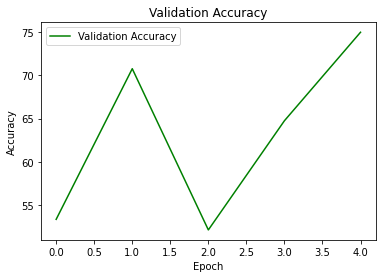

Embedding Dimension: 128, Hidden Size: 128, Batch Size: 300, Test Accuracy: 74.5343


Configuration 2:


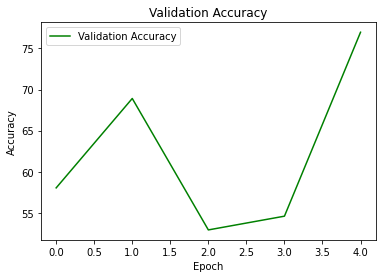

Embedding Dimension: 128, Hidden Size: 256, Batch Size: 300, Test Accuracy: 76.0584


Configuration 3:


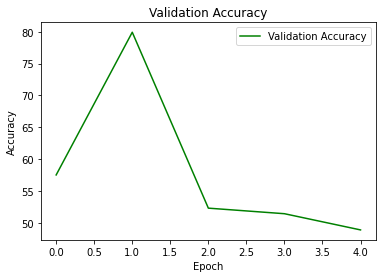

Embedding Dimension: 256, Hidden Size: 512, Batch Size: 300, Test Accuracy: 50.2590


Configuration 4:


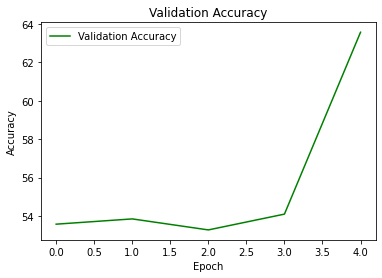

Embedding Dimension: 256, Hidden Size: 256, Batch Size: 300, Test Accuracy: 60.0558



In [25]:
import matplotlib.pyplot as plt


def plot_accuracy(val_accuracy):
    plt.plot(val_accuracy, label='Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.show()

for i, result in enumerate(results):
    config = result['config']
    train_losses = result['train_losses']
    val_losses = result['val_losses']
    val_accuracy = result['val_accuracy']
    test_accuracy = result['test_accuracy']

    print(f"\nConfiguration {i + 1}:")
    
    plot_accuracy(val_accuracy)

    print(f"Embedding Dimension: {config['embedding_dim']}, Hidden Size: {config['hidden_size']}, Batch Size: {config['batch_size']}, Test Accuracy: {test_accuracy:.4f}\n")


- The general observation from the above graph is that when the dimension and the hidden size is less the model yields more accuracy as the dimensions and the hidden size increase the model yields comparatively low accuaray 
- The reason might be that the cause of very high dim and hidden size the model might be overfitting, this means cause of the more sizes the model is memorizing the data instead of generalising it thereby giving us less accuracy
- And also theere is less data so cause of the higher dimensions and hidden sizes the model also needs very large data so this is giving us less accuracy and the same reason as the point 2

### 3. After RNNs
#### 3.1 Keeping all the parameters same, replace the RNN layer with the LSTM layer using nn.LSTM. What changes do you observe ? Explain why LSTM layer would affect performance.

In [22]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        #self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        embedded = self.embedding(X)
        lstm_out1, _ = self.lstm1(embedded)
        #lstm_out2, _ = self.lstm2(lstm_out1)
        lstm_out2 = torch.mean(lstm_out1, dim=1)
        logits = self.fc(lstm_out2)
        return logits


In [23]:
# create dataloaders using the dataset
params = {
    'batch_size':300,
    'shuffle': True,
}

train_dataloader = DataLoader(train_ds, **params)
val_dataloader = DataLoader(val_ds, **params)
test_dataloader = DataLoader(test_ds, **params)

hidden_size = 256
embedding_dim = 256
learning_rate = 1e-3
epochs = 5
num_classes = len(set(train_labels))
vocab_size = len(word2idx)+1

# create the model
model_LSTM = LSTMModel(vocab_size, hidden_size, embedding_dim, num_classes).to(device)


In [24]:
print(device)

cuda


In [25]:
train_losses, val_losses, val_accuracy = train_model(model_LSTM, train_dataloader, val_dataloader , epochs = 10)

Validation: 100%|██████████| 14/14 [00:02<00:00,  6.88it/s]


Epoch 1/10: Train Loss: 0.6877, Val Loss: 0.7013, Val Accuracy: 61.75%


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.41it/s]


Epoch 2/10: Train Loss: 0.6599, Val Loss: 0.6534, Val Accuracy: 63.67%


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.80it/s]


Epoch 3/10: Train Loss: 0.5875, Val Loss: 0.5393, Val Accuracy: 74.10%


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.78it/s]


Epoch 4/10: Train Loss: 0.4350, Val Loss: 0.4690, Val Accuracy: 79.74%


Validation: 100%|██████████| 14/14 [00:02<00:00,  6.79it/s]


Epoch 5/10: Train Loss: 0.3169, Val Loss: 0.3677, Val Accuracy: 84.46%


Validation: 100%|██████████| 14/14 [00:03<00:00,  3.66it/s]


Epoch 6/10: Train Loss: 0.2183, Val Loss: 0.3325, Val Accuracy: 86.23%


Validation: 100%|██████████| 14/14 [00:03<00:00,  3.95it/s]


Epoch 7/10: Train Loss: 0.1456, Val Loss: 0.3768, Val Accuracy: 86.25%


Validation: 100%|██████████| 14/14 [00:03<00:00,  3.94it/s]


Epoch 8/10: Train Loss: 0.1006, Val Loss: 0.3179, Val Accuracy: 87.10%


Validation: 100%|██████████| 14/14 [00:03<00:00,  3.95it/s]


Epoch 9/10: Train Loss: 0.0802, Val Loss: 0.4464, Val Accuracy: 85.70%


Validation: 100%|██████████| 14/14 [00:03<00:00,  4.00it/s]

Epoch 10/10: Train Loss: 0.0533, Val Loss: 0.4908, Val Accuracy: 86.63%


In [26]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for input_batch, output_batch in tqdm(test_loader):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            #get outputs from the trained model
            pred_outputs = model(input_batch)
            _, predicted = torch.max(pred_outputs, dim=1)  # Get predicted class labels
            total += output_batch.size(0)
            correct += (predicted == output_batch).sum().item()

    accuracy = 100 * (correct / total)
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

accuracy = test(model_LSTM, test_dataloader)

100%|██████████| 67/67 [00:16<00:00,  4.15it/s]

Test Accuracy: 84.88%
